In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import gev_utils as gevu
import gev_nonstat_utils as gevns
import sa_utils as sau
import plotting_utils as pu

from utils import city_list
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, gard_gcms

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### Preliminaries

In [ ]:
def plot_uc_single_metric(metric_id, hist_slice, title, save_path, vmax_uc=30):
    """
    Plots all return level UC maps for a single metric.
    """
    fig = plt.figure(figsize=(12, 11), layout='constrained')
    subfigs = fig.subfigures(4, 1, hspace=0.03)

    for idp, return_period in enumerate([10,25,50,100]):
        # Get info
        axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
        plot_col = f"{return_period}yr_return_level"
        subfig_title = f"{return_period}-year return level"
        # Plot
        pu.plot_uc_map(
            metric_id=metric_id,
            proj_slice="2050-2100",
            hist_slice=hist_slice,
            plot_col=plot_col,
            return_period=return_period,
            grid="LOCA2",
            fit_method="lmom",
            stationary=True,
            analysis_type="extreme_value",
            regrid_method="nearest",
            norm="uc_99w",
            vmax_uc=vmax_uc,
            fig=subfigs[idp],
            axs=axs,
            title=subfig_title,
        )
    fig.suptitle(title, fontweight="bold")
    if save_path is not None:
        plt.savefig(f'../figs/{save_path}.png', dpi=300)
    else:
        plt.show()

## Analysis

In [5]:
# Non-stationary, no bootstrap
grid = "LOCA2"
regrid_method = "nearest"
proj_slice = "1950-2100"
hist_slice = None
return_levels = [10,25,50,100]
fit_method = "mle"
stationary = False
stat_str = "stat" if stationary else "nonstat"

preprocess_funcs = {
    '2075-1975': lambda x: x.sel(time=2075) - x.sel(time=1975), # change
    '2075': lambda x: x.sel(time=2075), # absolute projection
}

# Loop through metrics
for metric_id in gev_metric_ids[:3]:
    # Do for projection, change
    for preprocess_func_name in preprocess_funcs.keys():
        _preprocess_func = preprocess_funcs[preprocess_func_name]
        # Loop through return levels
        for return_level in return_levels:
            # Check if done
            col_name = f"{return_level}yr_return_level"
            save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{col_name}_{preprocess_func_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}.nc"
            # Calculate
            if not os.path.exists(save_path):
                uc = sau.uc_all(metric_id=metric_id,
                                grid=grid,
                                fit_method=fit_method,
                                stationary=stationary,
                                regrid_method=regrid_method,
                                proj_slice=proj_slice,
                                hist_slice=hist_slice,
                                col_name=col_name,
                                compute_fit_uc=False,
                                _preprocess_func=_preprocess_func
                               )
                # Store
                uc.to_netcdf(save_path)
                print(f"Done: {save_path.split('/')[-1]}")
                del uc # memory management
            else:
                print(f"Already done: {save_path.split('/')[-1]}")

Already done: max_tasmax_1950-2100_100yr_return_level_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_100yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_100yr_return_level_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_100yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_100yr_return_level_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_100yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc


In [6]:
# Stationary, bootstrap
grid = "LOCA2"
regrid_method = "nearest"
proj_slice = "2050-2100"
hist_slices = [None, "1950-2014"]
return_levels = [10,25,50,100]
fit_method = "lmom"
stationary = True
stat_str = "stat" if stationary else "nonstat"

# Loop through metrics
for metric_id in gev_metric_ids:
    # Do for projection, change
    for hist_slice in hist_slices:
        # Loop through return levels
        for return_level in return_levels:
            # Check if done
            col_name = f"{return_level}yr_return_level"
            save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{hist_slice}_{col_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}.nc"
            # Calculate
            if not os.path.exists(save_path):
                
                uc = sau.uc_all(metric_id=metric_id,
                            grid=grid,
                            fit_method=fit_method,
                            stationary=stationary,
                            regrid_method=regrid_method,
                            proj_slice=proj_slice,
                            hist_slice=hist_slice,
                            col_name=col_name)
                # Store
                uc.to_netcdf(save_path)
                print(f"Done: {save_path.split('/')[-1]}")
                del uc # memory management
            else:
                print(f"Already done: {save_path.split('/')[-1]}")

Already done: max_tasmax_2050-2100_None_10yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_25yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_50yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_100yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_10yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_25yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_50yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_100yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: min_tasmin_2050-2100_None_10yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: min_tasmin_2050-2100_None_25yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: min_tasmin_2050-2100_None_50yr_return_level_lmom_stat_LOCA2grid_nearest.nc

## Plots

### Non-maps

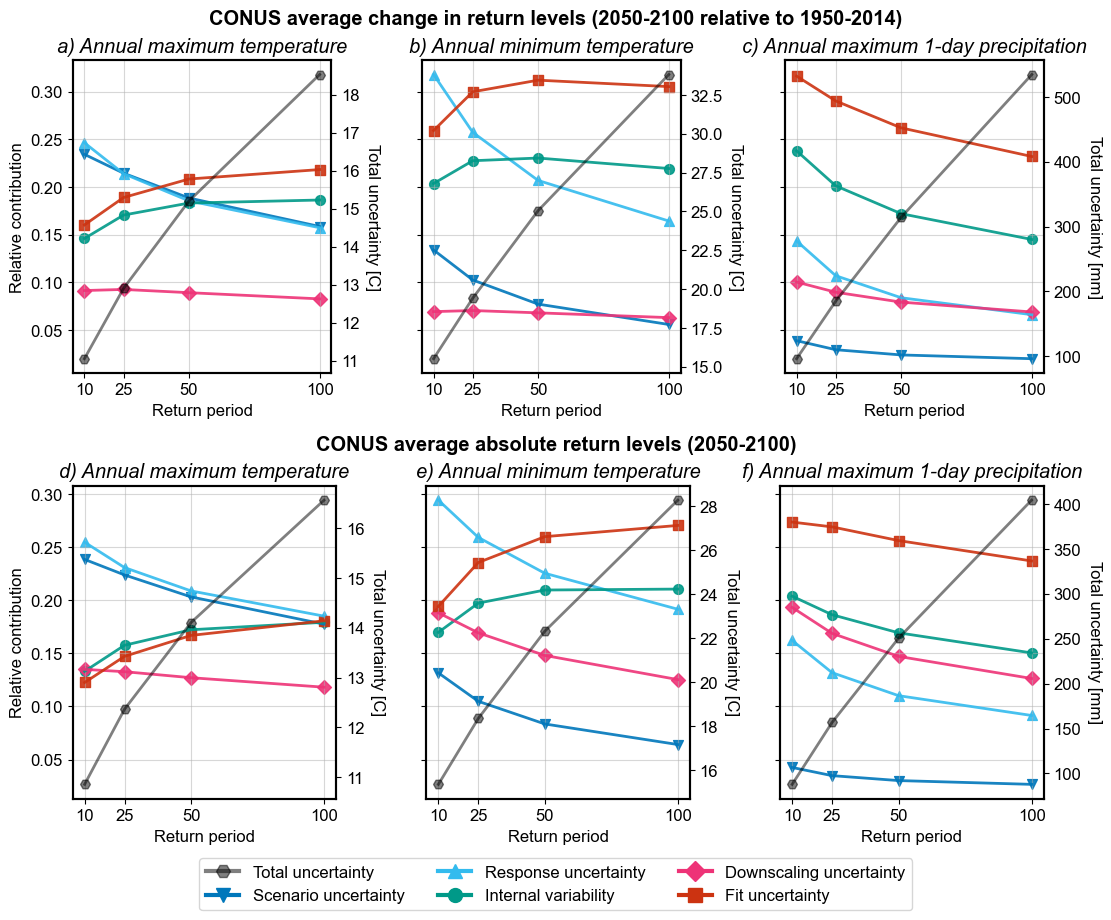

In [4]:
# Main: figure 3
proj_slice = '2050-2100'
fit_method = 'lmom'
stat_str = 'stat'
grid = 'LOCA2'
regrid_method = 'nearest'
return_periods = [10,25,50,100]
total_uc = 'uc_99w'

fig = plt.figure(layout='constrained', figsize=(11, 9))
subfigs = fig.subfigures(3, 1, hspace=0.12, height_ratios=[8,8,1])

# Top tow: change from historical
hist_slice = '1950-2014'
axsTop = subfigs[0].subplots(1, 3, sharey=True, gridspec_kw={"wspace": 0.1})

pu.plot_uc_rls(
    coord_or_mean="mean",
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title = "CONUS average change in return levels (2050-2100 relative to 1950-2014)",
    fig = subfigs[0], 
    axs = axsTop,
    store_path = None,
    legend = False,
    y_title = 1.06
)

# Bottom row: abolute
hist_slice = None
axsBottom = subfigs[1].subplots(1, 3, sharey=True, gridspec_kw={"wspace": 0.1})

legend_elements = pu.plot_uc_rls(
    coord_or_mean="mean",
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title = "CONUS average absolute return levels (2050-2100)",
    fig = subfigs[1], 
    axs = axsBottom,
    store_path = None,
    legend=False,
    idm_start=3,
    return_legend=True,
    y_title = 1.06
)

# Add legend
subfigs[2].legend(handles=legend_elements,
                  bbox_to_anchor=[0.5, 1.0],
                  loc='center',
                  fontsize=12,
                  ncol=3)

plt.savefig('../figs/main/extreme_nonstat_spatial_avg.pdf', bbox_inches='tight')

In [ ]:
# Main: figure 3
proj_slice = '2050-2100'
fit_method = 'mle'
stat_str = 'nonstat'
grid = 'LOCA2'
regrid_method = 'nearest'
return_periods = [10,25,50,100]
total_uc = 'uc_99w'

fig = plt.figure(layout='constrained', figsize=(11, 9))
subfigs = fig.subfigures(3, 1, hspace=0.12, height_ratios=[8,8,1])

# Top tow: change from historical
hist_slice = '1950-2014'
axsTop = subfigs[0].subplots(1, 3, sharey=True, gridspec_kw={"wspace": 0.1})

pu.plot_uc_rls(
    coord_or_mean="mean",
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title = "CONUS average change in return levels (2050-2100 relative to 1950-2014)",
    fig = subfigs[0], 
    axs = axsTop,
    store_path = None,
    legend = False,
    y_title = 1.06
)

# Bottom row: abolute
hist_slice = None
axsBottom = subfigs[1].subplots(1, 3, sharey=True, gridspec_kw={"wspace": 0.1})

legend_elements = pu.plot_uc_rls(
    coord_or_mean="mean",
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title = "CONUS average absolute return levels (2050-2100)",
    fig = subfigs[1], 
    axs = axsBottom,
    store_path = None,
    legend=False,
    idm_start=3,
    return_legend=True,
    y_title = 1.06
)

# Add legend
subfigs[2].legend(handles=legend_elements,
                  bbox_to_anchor=[0.5, 1.0],
                  loc='center',
                  fontsize=12,
                  ncol=3)

plt.savefig('../figs/main/extreme_nonstat_spatial_avg.pdf', bbox_inches='tight')

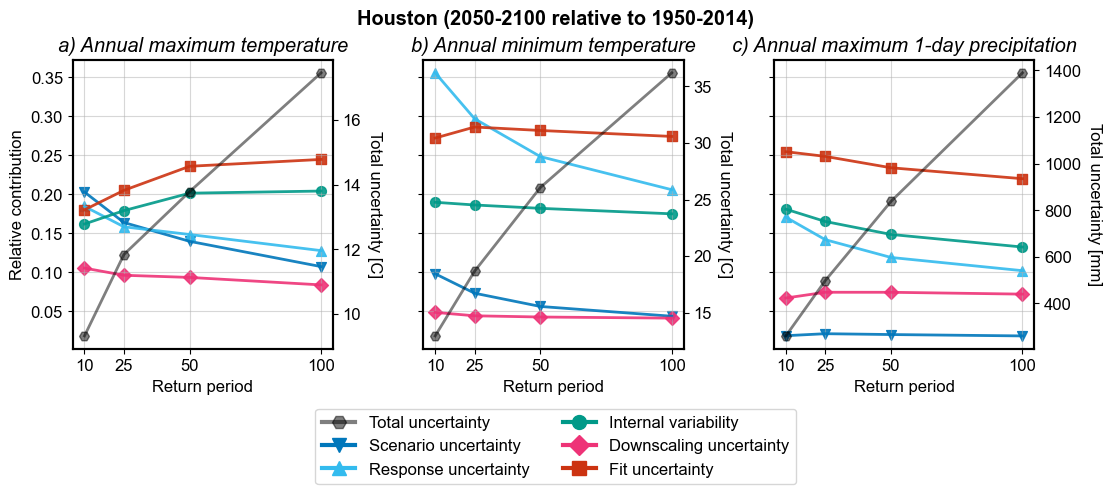

In [6]:
proj_slice = '2050-2100'
hist_slice = '1950-2014'
fit_method = 'lmom'
stat_str = 'stat'
grid = 'LOCA2'
regrid_method = 'nearest'
return_periods = [10,25,50,100]
total_uc = 'uc_99w'

pu.plot_uc_rls(
    coord_or_mean=city_list['houston'],
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title="Houston (2050-2100 relative to 1950-2014)",
)

In [ ]:
proj_slice = '2050-2100'
hist_slice = '1950-2014'
fit_method = 'lmom'
stat_str = 'nonstat'
grid = 'LOCA2'
regrid_method = 'nearest'
return_periods = [10,25,50,100]
total_uc = 'uc_99w'

pu.plot_uc_rls(
    coord_or_mean=city_list['houston'],
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title="Houston (2050-2100 relative to 1950-2014)",
)

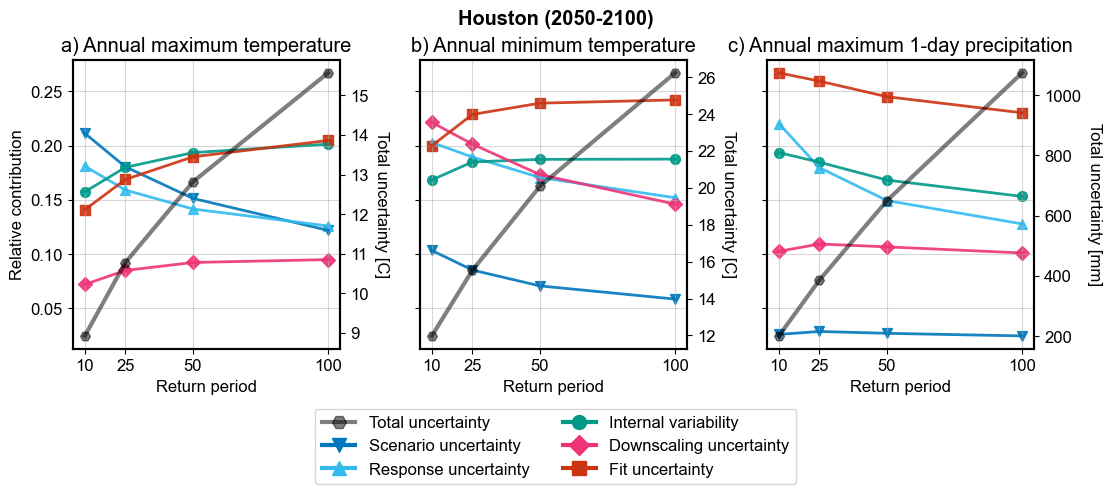

In [31]:
proj_slice = '2050-2100'
hist_slice = None
fit_method = 'lmom'
stat_str = 'stat'
grid = 'LOCA2'
regrid_method = 'nearest'
return_periods = [10,25,50,100]
total_uc = 'uc_99w'

pu.plot_uc_rls(
    coord_or_mean=city_list['houston'],
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    regrid_method=regrid_method,
    title="Houston (2050-2100)",
)

### Maps

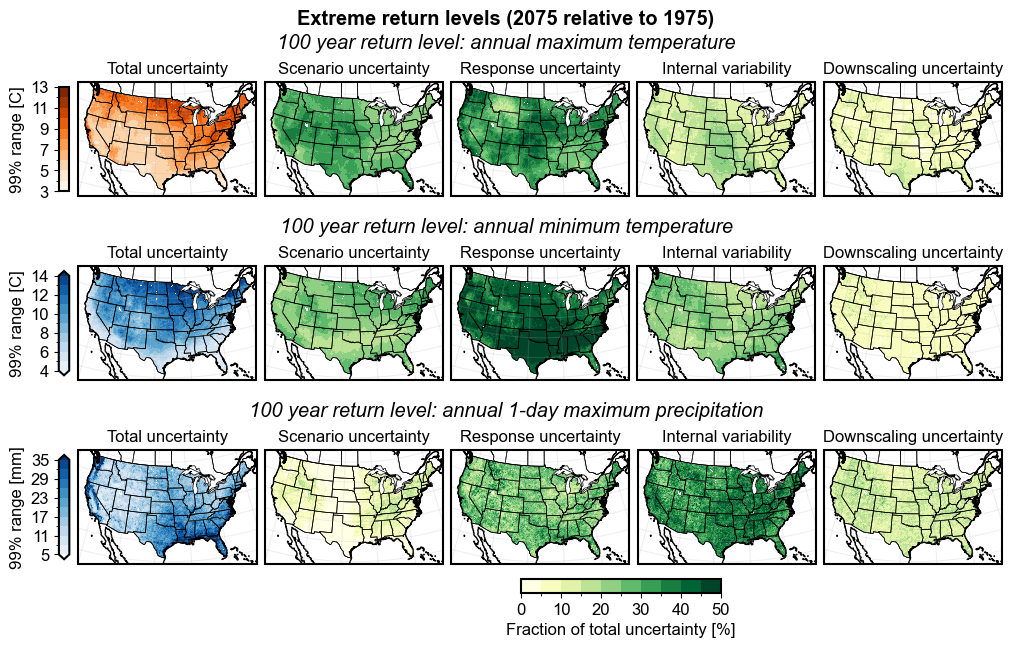

In [13]:
# Main plot
proj_slice = '1950-2100'
hist_slice = None
col_name = '2075-1975'
return_period = 100
fit_method = 'mle'
stat_str = "nonstat"
grid = 'LOCA2'
norm = 'uc_99w'
regrid_method = "nearest"

fig = plt.figure(figsize=(10, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("Extreme return levels (2075 relative to 1975)", fontweight="bold", y=1.07)

plot_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

# Loop through metrics
for idp, metric_id in enumerate(plot_metric_ids):
    axs = subfigs[idp].subplots(1, 5, subplot_kw=dict(projection=ccrs.LambertConformal()))
    file_name = f"{metric_id}_{proj_slice}_{return_period}yr_return_level_{col_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}"
    p = pu.plot_uc_map(
        file_name = file_name,
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=False,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 50,
        y_title = 1.08,
        fig=subfigs[idp],
        axs=axs,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/main/extreme_nonstat_change.png', dpi=300, bbox_inches='tight')
# plt.show()

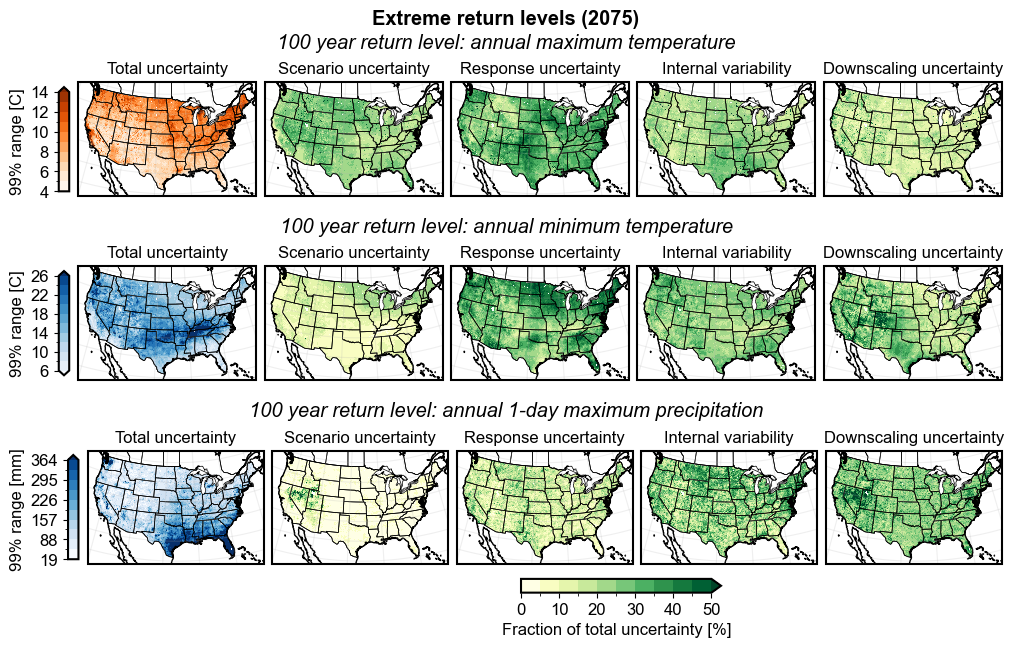

In [14]:
# Non-stationary absolute projection
proj_slice = '1950-2100'
hist_slice = None
col_name = '2075'
return_period = 100
fit_method = 'mle'
stat_str = "nonstat"
grid = 'LOCA2'
norm = 'uc_99w'
regrid_method = "nearest"

fig = plt.figure(figsize=(10, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("Extreme return levels (2075)", fontweight="bold", y=1.07)

plot_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

# Loop through metrics
for idp, metric_id in enumerate(plot_metric_ids):
    axs = subfigs[idp].subplots(1, 5, subplot_kw=dict(projection=ccrs.LambertConformal()))
    file_name = f"{metric_id}_{proj_slice}_{return_period}yr_return_level_{col_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}"
    p = pu.plot_uc_map(
        file_name = file_name,
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=False,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 50,
        y_title = 1.08,
        fig=subfigs[idp],
        axs=axs,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/main/extreme_nonstat_abs.png', dpi=300, bbox_inches='tight')
# plt.show()

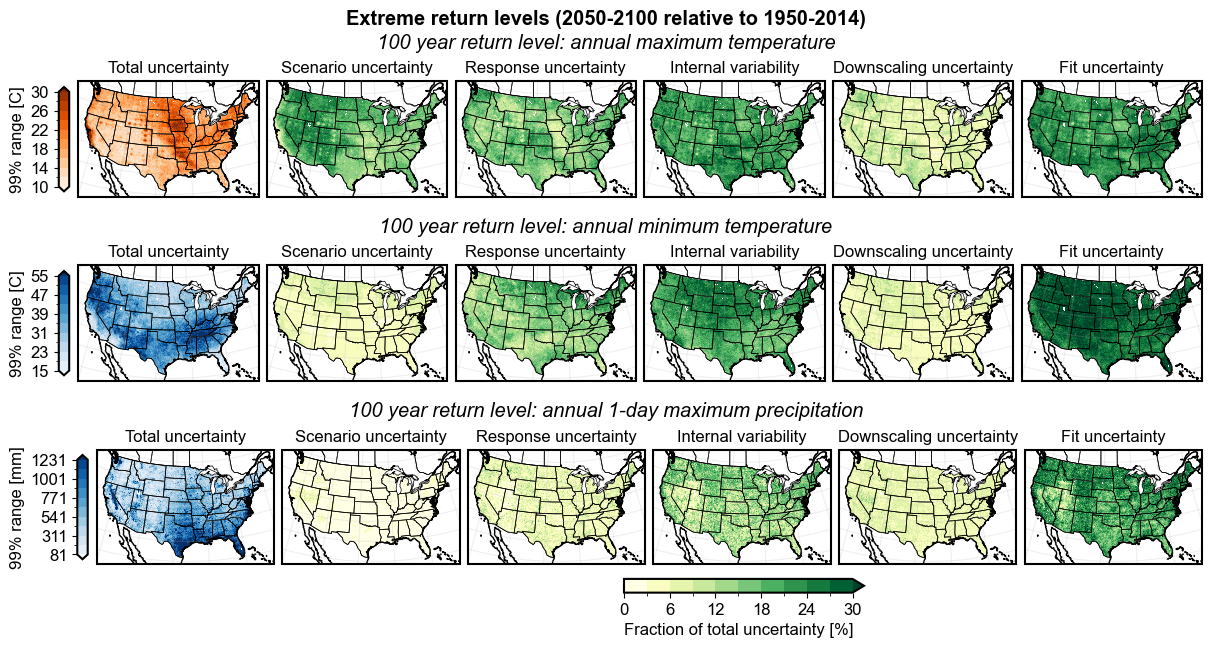

In [18]:
# Main plot
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100
fit_method = 'lmom'
stat_str = "stat"
grid = 'LOCA2'
norm = 'uc_99w'

fig = plt.figure(figsize=(12, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("Extreme return levels (2050-2100 relative to 1950-2014)", fontweight="bold", y=1.07)

# Loop through metrics
for idp, metric_id in enumerate(gev_metric_ids[:-2]):
    axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
    file_name = f"{metric_id}_{proj_slice}_{hist_slice}_{return_period}yr_return_level_{fit_method}_{stat_str}_{grid}grid_{regrid_method}"
    p = pu.plot_uc_map(
        file_name = file_name,
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=stationary,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 30,
        y_title = 1.08,
        fig=subfigs[idp],
        axs=axs,
        plot_fit_uc=True,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/main/extreme_stat_change.png', dpi=300, bbox_inches='tight')

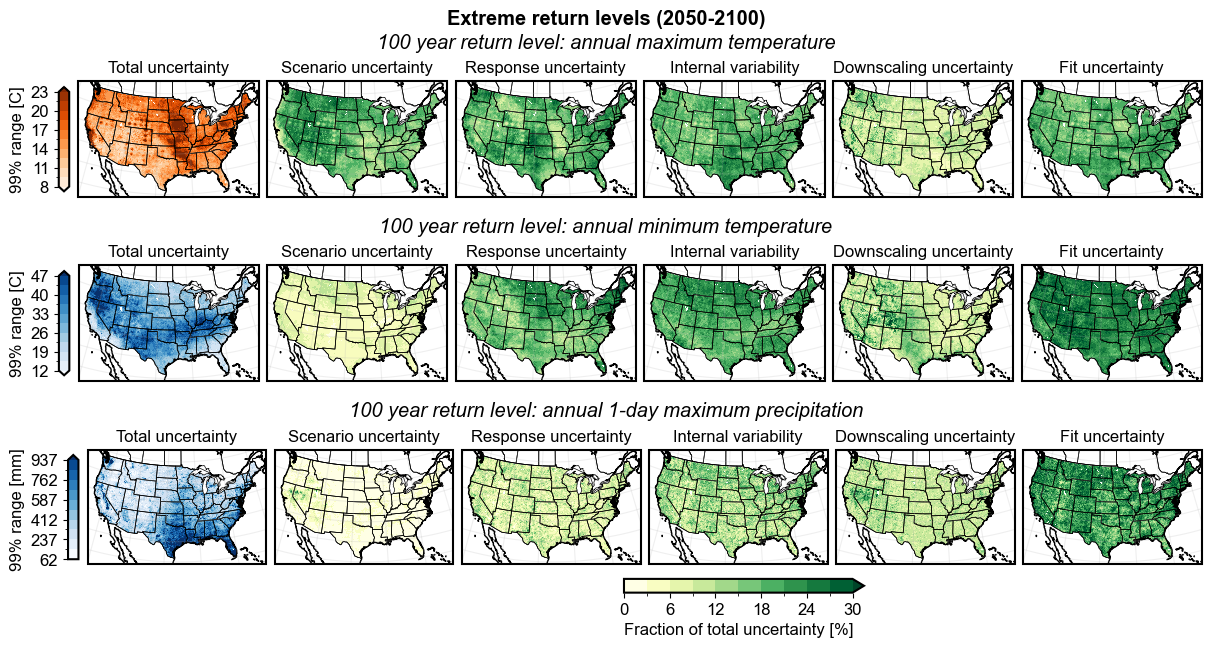

In [20]:
# Main plot
proj_slice = '2050-2100'
hist_slice = None
return_period = 100
fit_method = 'lmom'
stat_str = "stat"
grid = 'LOCA2'
norm = 'uc_99w'

fig = plt.figure(figsize=(12, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("Extreme return levels (2050-2100)", fontweight="bold", y=1.07)

# Loop through metrics
for idp, metric_id in enumerate(gev_metric_ids[:-2]):
    axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
    file_name = f"{metric_id}_{proj_slice}_{hist_slice}_{return_period}yr_return_level_{fit_method}_{stat_str}_{grid}grid_{regrid_method}"
    p = pu.plot_uc_map(
        file_name=file_name,
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=stationary,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 30,
        y_title = 1.08,
        fig=subfigs[idp],
        axs=axs,
        plot_fit_uc=True,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/main/extreme_stat_abs.png', dpi=300, bbox_inches='tight')

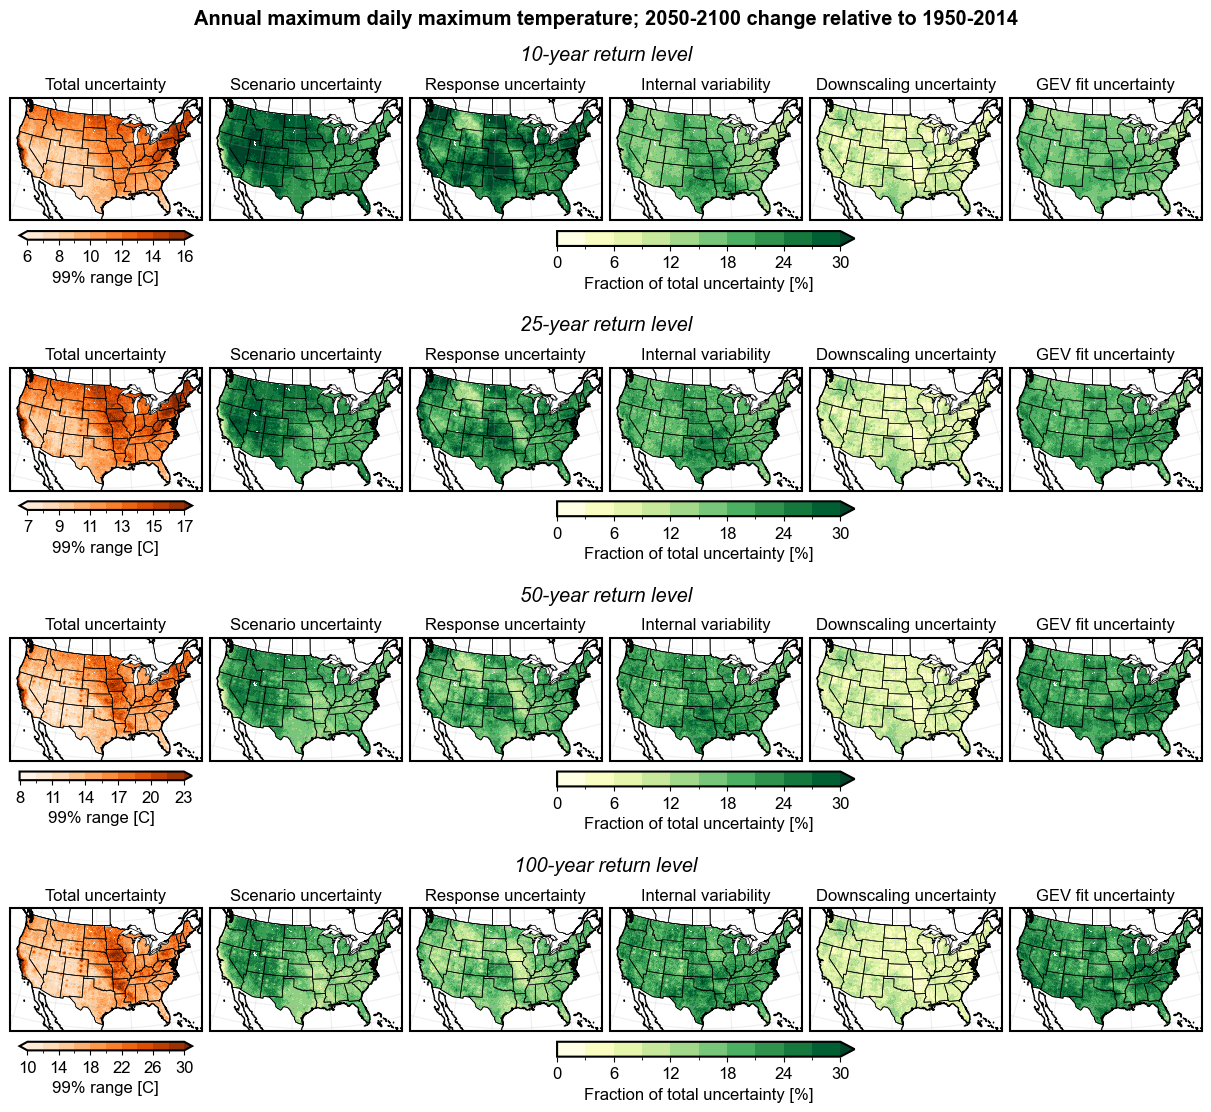

In [6]:
plot_uc_single_metric(metric_id = "max_tasmax", 
                      hist_slice = "1950-2014",
                      title = "Annual maximum daily maximum temperature; 2050-2100 change relative to 1950-2014",
                      save_path = "max_tasmax_change_all_RLs")

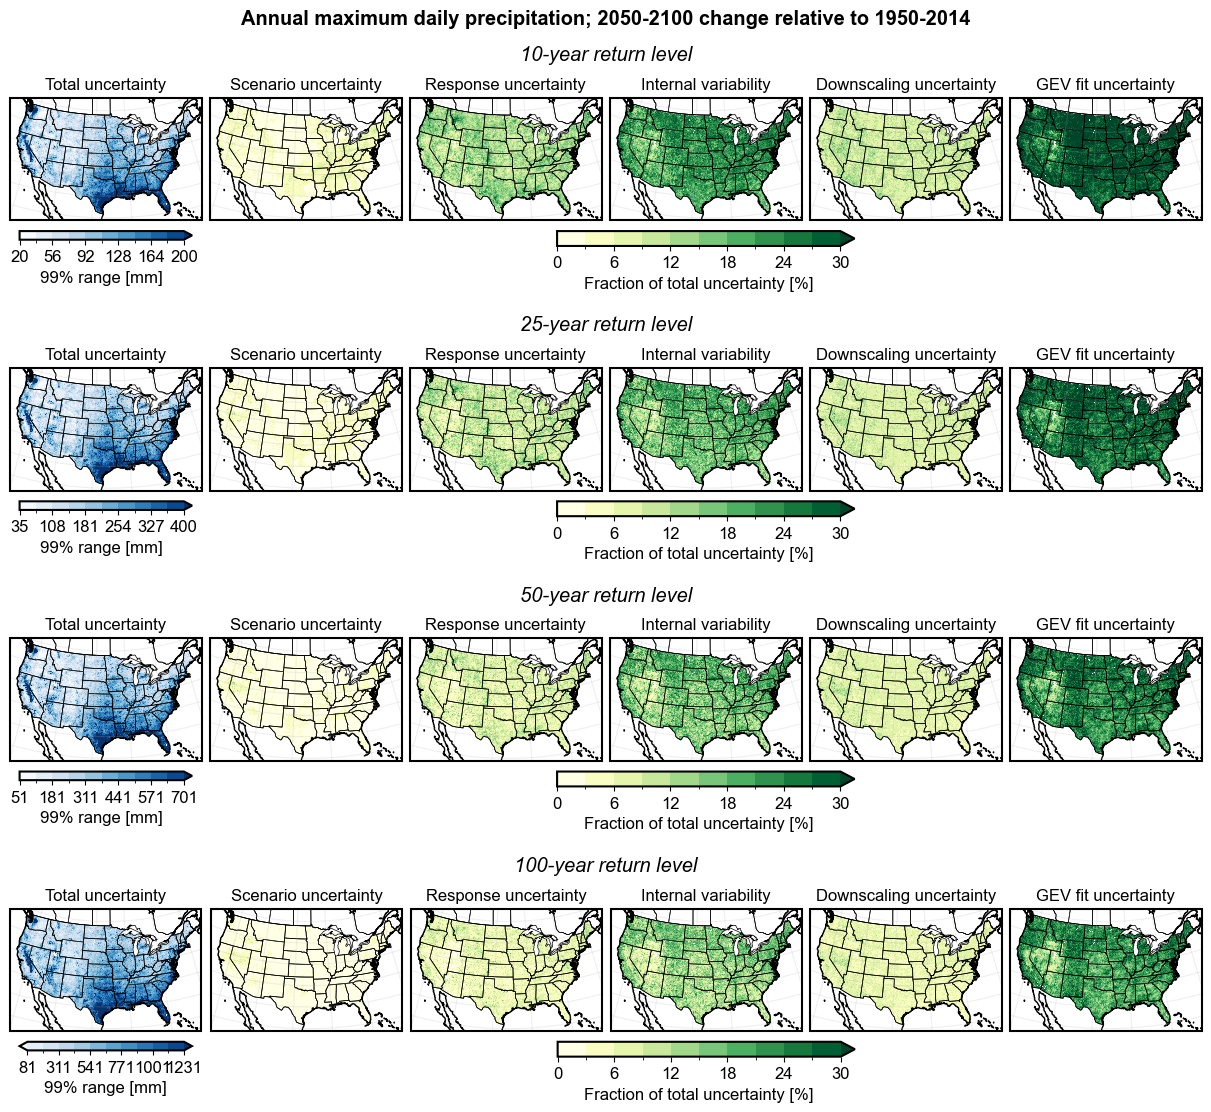

In [7]:
plot_uc_single_metric(metric_id = "max_pr", 
                      hist_slice = "1950-2014",
                      title = "Annual maximum daily precipitation; 2050-2100 change relative to 1950-2014",
                      save_path = "max_pr_change_all_RLs")

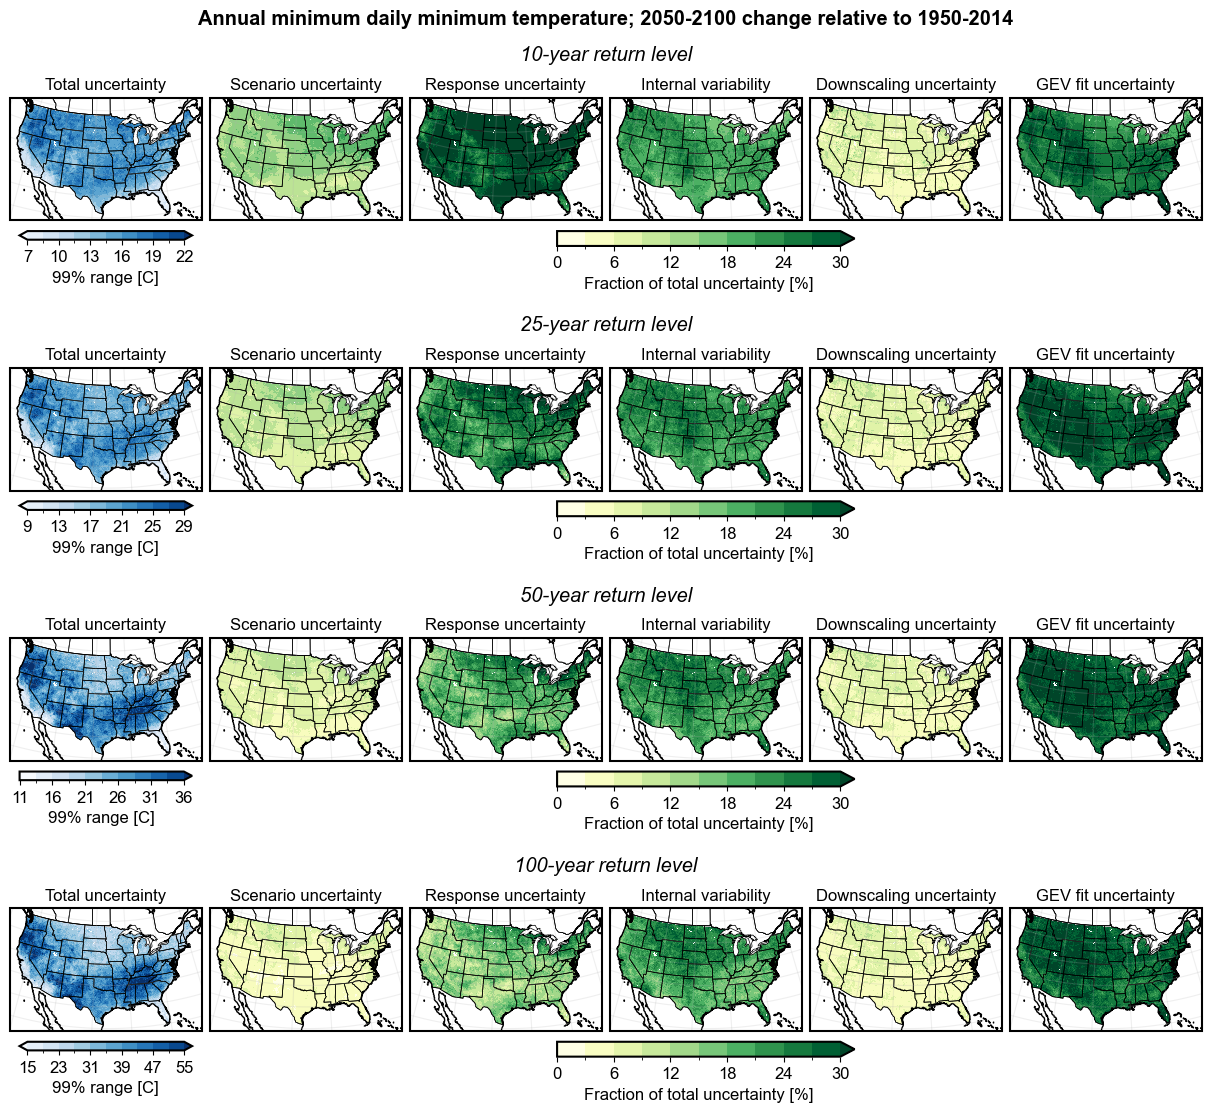

In [8]:
plot_uc_single_metric(metric_id = "min_tasmin", 
                      hist_slice = "1950-2014",
                      title = "Annual minimum daily minimum temperature; 2050-2100 change relative to 1950-2014",
                      save_path = "min_tasmin_change_all_RLs")

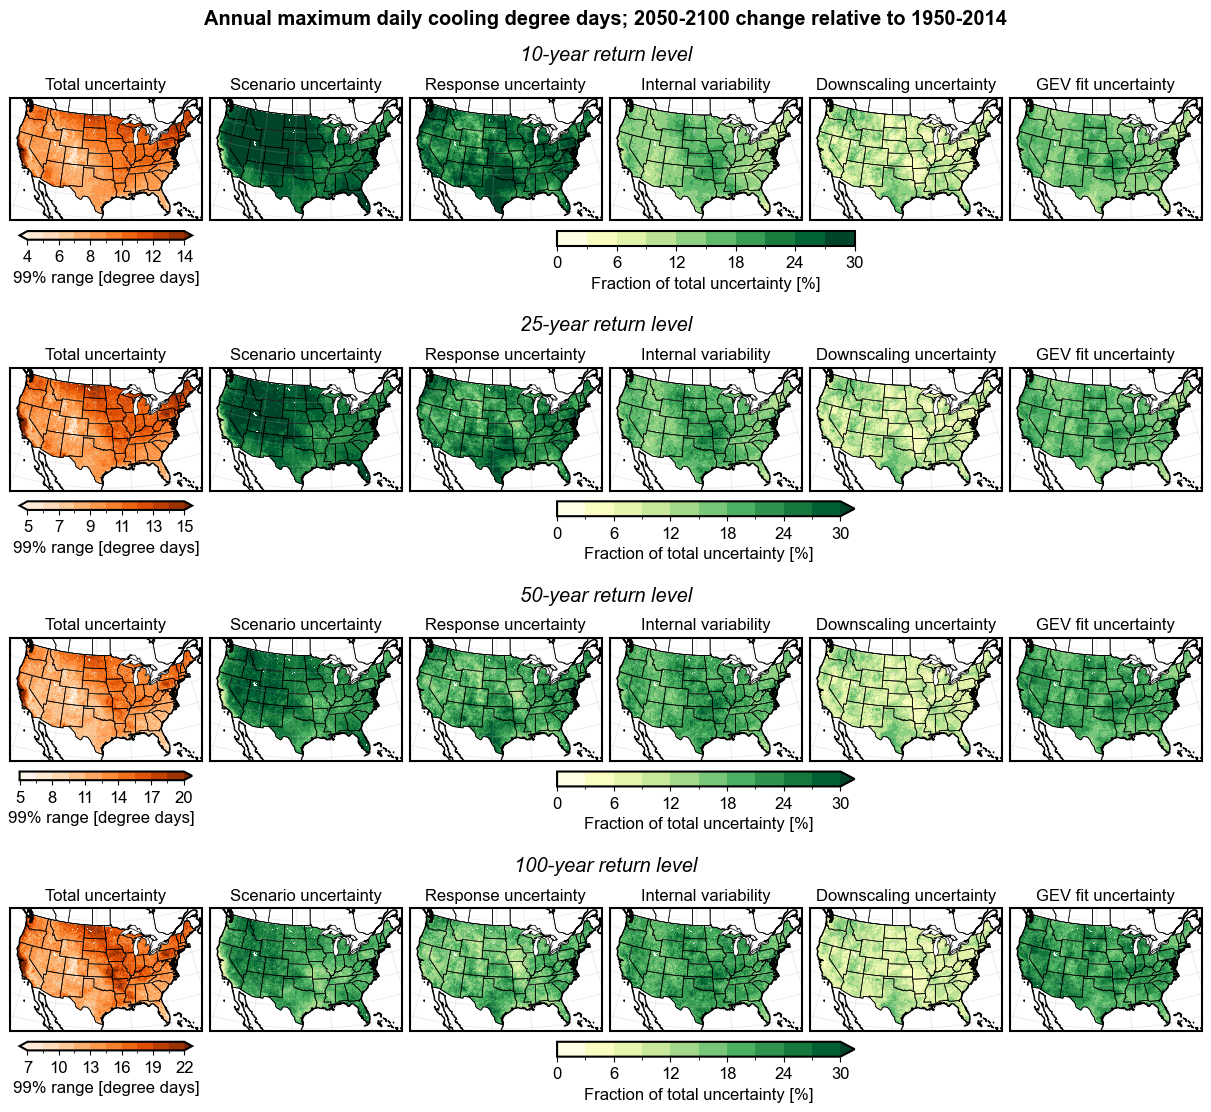

In [11]:
plot_uc_single_metric(metric_id = "max_cdd", 
                      hist_slice = "1950-2014",
                      title = "Annual maximum daily cooling degree days; 2050-2100 change relative to 1950-2014",
                      save_path = "max_cdd_change_all_RLs")

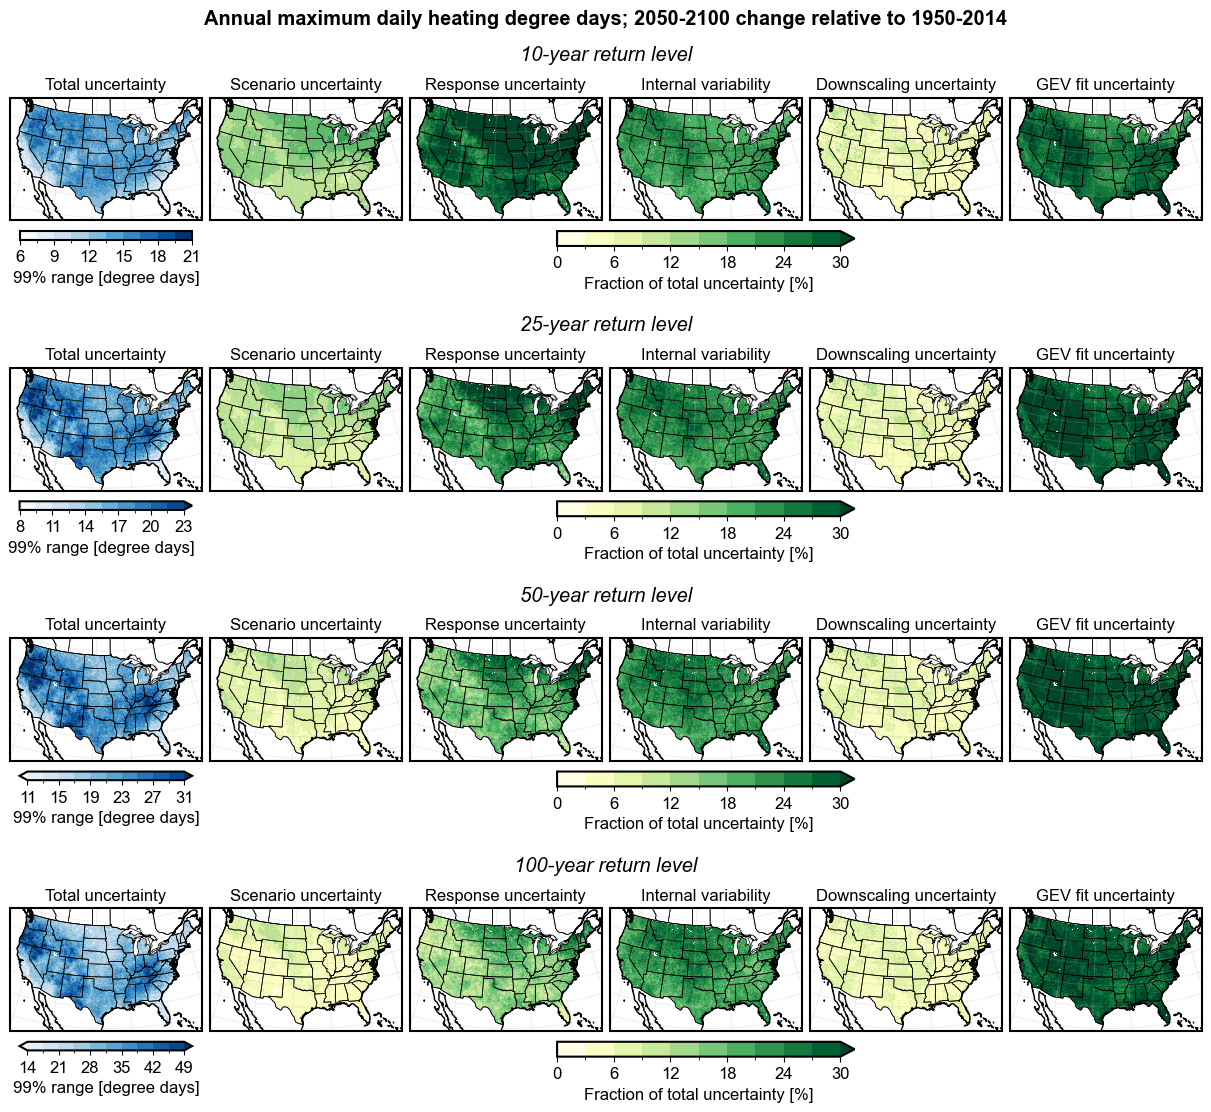

In [12]:
plot_uc_single_metric(metric_id = "max_hdd", 
                      hist_slice = "1950-2014",
                      title = "Annual maximum daily heating degree days; 2050-2100 change relative to 1950-2014",
                      save_path = "max_hdd_change_all_RLs")